In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model

from keras import *
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from tensorflow.keras import regularizers
from keras.optimizers import Adam, RMSprop
from keras.backend import clear_session

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
train = pd.read_csv("/content/drive/MyDrive/AML project/train_manipulated_integrated.csv")

In [3]:
## preparazione train e validation set

## preparazione train e validation set

y_train = train['trip_duration'].values.reshape(-1, 1)

X_train = train.drop(columns = ['trip_duration'])

#si separano le dummies dalle quantitative

X_train_to_stand = X_train[['passenger_count', 'distance',
                                            'maximum temperature', 'minimum temperature',
                                           'average temperature',
                                           'precipitation', 
                                           'snow fall',
                                           'snow depth', 'direction']]

X_train_not_stand = X_train.drop(columns = ['passenger_count', 'distance',
                                            'maximum temperature', 'minimum temperature',
                                           'average temperature',
                                           'precipitation', 
                                           'snow fall',
                                           'snow depth', 'direction']).values

In [4]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_to_stand)
y_train = scaler.fit(y_train).fit_transform(y_train)

In [5]:
X_train = np.concatenate((X_train, X_train_not_stand), axis = 1)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3,
                                                  random_state = 1234)

In [7]:
X_train.shape

(1008303, 48)

In [12]:
#modello non ottimizzato

initializer = tf.keras.initializers.GlorotUniform()

opt = tf.keras.optimizers.SGD(learning_rate=0.002 , momentum=0.3, 
                              nesterov = False)

model_no_opt = Sequential()
model_no_opt.add(Dense(256, input_shape = (48,),
                activation = "relu", 
                kernel_initializer=initializer))
model_no_opt.add(Dropout(0.2))
model_no_opt.add(Dense(128,
                activation = "relu", 
                kernel_initializer=initializer))
model_no_opt.add(Dropout(0.2))
model_no_opt.add(Dense(128,
                activation = "relu", 
                kernel_initializer=initializer))
model_no_opt.add(Dropout(0.2))
model_no_opt.add(Dense(32,
                activation = "relu", 
                kernel_initializer=initializer))
model_no_opt.add(Dropout(0.2))
model_no_opt.add(Dense(1,
                activation = "linear", 
                kernel_initializer=initializer))
model_no_opt.compile(loss = "mse", optimizer=opt, metrics = [tf.keras.metrics.RootMeanSquaredError()])

model_no_opt.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               12544     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)               

In [13]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)

history_no_opt = model_no_opt.fit(X_train, y_train, epochs = 100, 
            batch_size = 128, validation_data=(X_val, y_val),
            shuffle = True,
            callbacks = es,
            verbose=2)

Epoch 1/100
7878/7878 - 36s - loss: 0.4560 - root_mean_squared_error: 0.6753 - val_loss: 0.3469 - val_root_mean_squared_error: 0.5890
Epoch 2/100
7878/7878 - 35s - loss: 0.3832 - root_mean_squared_error: 0.6190 - val_loss: 0.3291 - val_root_mean_squared_error: 0.5737
Epoch 3/100
7878/7878 - 35s - loss: 0.3619 - root_mean_squared_error: 0.6016 - val_loss: 0.3161 - val_root_mean_squared_error: 0.5623
Epoch 4/100
7878/7878 - 35s - loss: 0.3494 - root_mean_squared_error: 0.5911 - val_loss: 0.3118 - val_root_mean_squared_error: 0.5584
Epoch 5/100
7878/7878 - 35s - loss: 0.3405 - root_mean_squared_error: 0.5835 - val_loss: 0.3113 - val_root_mean_squared_error: 0.5579
Epoch 6/100
7878/7878 - 35s - loss: 0.3354 - root_mean_squared_error: 0.5791 - val_loss: 0.2979 - val_root_mean_squared_error: 0.5458
Epoch 7/100
7878/7878 - 37s - loss: 0.3307 - root_mean_squared_error: 0.5751 - val_loss: 0.2989 - val_root_mean_squared_error: 0.5467
Epoch 8/100
7878/7878 - 35s - loss: 0.3268 - root_mean_squared

In [14]:
train_no_opt_mse = history_no_opt.history['loss']
val_no_opt_mse = history_no_opt.history['val_loss']

train_no_opt_rmse = history_no_opt.history['root_mean_squared_error']
val_no_opt_rmse = history_no_opt.history['val_root_mean_squared_error']

In [20]:
perf_no_opt_dropout = pd.DataFrame({'epochs': list(np.arange(0, 79)[0:79]), 
                               'loss':train_no_opt_mse,
                               'val_loss':val_no_opt_mse,
                               'rmse': train_no_opt_rmse,
                               'val_rmse': val_no_opt_rmse})

#backup per non riallenare
perf_no_opt_dropout.to_csv("/content/drive/MyDrive/perf_no_opt_dropout.csv", index = False)
model_no_opt.save("/content/drive/MyDrive/model_no_opt_dropout.h5")

In [16]:
#modello ottimizzato

activations = "relu"
units_1 = 240
units_2 = 112
units_3 = 128

dropout = 0.10

initializer = tf.keras.initializers.GlorotUniform(1234)

opt = tf.keras.optimizers.SGD(learning_rate= 0.002, momentum=0.3, 
                              nesterov = False)


model = Sequential()
model.add(Dense(units_1, input_shape = (48,),
                activation = activations, 
                kernel_initializer=initializer))
model.add(Dropout(dropout, seed = 1000))
model.add(Dense(units_2,
                activation = activations, 
                kernel_initializer=initializer))
model.add(Dropout(dropout, seed = 1000))
model.add(Dense(units_3,
                activation = activations, 
                kernel_initializer=initializer))
model.add(Dropout(dropout, seed = 1000))
model.add(Dense(1,
                activation = "linear", 
                kernel_initializer=initializer))
model.compile(loss = "mse", optimizer=opt
, metrics = [tf.keras.metrics.RootMeanSquaredError()])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 240)               11760     
_________________________________________________________________
dropout_11 (Dropout)         (None, 240)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 112)               26992     
_________________________________________________________________
dropout_12 (Dropout)         (None, 112)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               14464     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

In [17]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs = 100, 
            batch_size = 128, validation_data=(X_val, y_val),
            callbacks = es,
            verbose=2)

Epoch 1/100
7878/7878 - 30s - loss: 0.3986 - root_mean_squared_error: 0.6314 - val_loss: 0.3266 - val_root_mean_squared_error: 0.5715
Epoch 2/100
7878/7878 - 32s - loss: 0.3426 - root_mean_squared_error: 0.5853 - val_loss: 0.3087 - val_root_mean_squared_error: 0.5556
Epoch 3/100
7878/7878 - 30s - loss: 0.3264 - root_mean_squared_error: 0.5713 - val_loss: 0.2994 - val_root_mean_squared_error: 0.5472
Epoch 4/100
7878/7878 - 30s - loss: 0.3184 - root_mean_squared_error: 0.5642 - val_loss: 0.2950 - val_root_mean_squared_error: 0.5431
Epoch 5/100
7878/7878 - 29s - loss: 0.3130 - root_mean_squared_error: 0.5594 - val_loss: 0.2916 - val_root_mean_squared_error: 0.5400
Epoch 6/100
7878/7878 - 31s - loss: 0.3087 - root_mean_squared_error: 0.5556 - val_loss: 0.2912 - val_root_mean_squared_error: 0.5396
Epoch 7/100
7878/7878 - 30s - loss: 0.3053 - root_mean_squared_error: 0.5526 - val_loss: 0.2875 - val_root_mean_squared_error: 0.5362
Epoch 8/100
7878/7878 - 29s - loss: 0.3025 - root_mean_squared

In [21]:
y_pred = model.predict(X_val)
y_pred_no_opt = model_no_opt.predict(X_val)

In [22]:
r_quadro = r2_score(y_val, y_pred)
r_quadro_no_opt = r2_score(y_val, y_pred_no_opt)

print("r_quadro opt ", r_quadro)
print("r_quadro no opt ", r_quadro_no_opt)

r_quadro opt  0.7539845205264405
r_quadro no opt  0.7373927770305921


In [23]:
metrics_no_opt = model_no_opt.evaluate(X_val, y_val, verbose = 0, batch_size = 128)
metrics_opt = model.evaluate(X_val, y_val, verbose = 0, batch_size = 128)

mse_no_opt = metrics_no_opt[0] #mse
rmse_no_opt = metrics_no_opt[1] #rmse

mse_opt = metrics_opt[0] #mse
rmse_opt = metrics_opt[1] #rmse

print("mse no opt ", mse_no_opt)
print("mse opt ", mse_opt)

print("rmse no opt " , rmse_no_opt)
print("rmse opt", rmse_opt)

mse no opt  0.26338231563568115
mse opt  0.24674206972122192
rmse no opt  0.5132078528404236
rmse opt 0.49673140048980713


In [24]:
train_opt_loss = history.history['loss']
val_opt_loss = history.history['val_loss']

train_opt_rmse = history.history['root_mean_squared_error']
val_opt_rmse = history.history['val_root_mean_squared_error']

perf_opt_dropout = pd.DataFrame({'epochs': list(np.arange(0, 100)[0:100]), 
                               'loss':train_opt_loss,
                               'val_loss':val_opt_loss,
                            'rmse': train_opt_rmse,
                            'val_rmse':val_opt_rmse})

#backup per npn riallenare
perf_opt_dropout.to_csv("/content/drive/MyDrive/perf_opt_dropout.csv", index = False)
model.save("/content/drive/MyDrive/model_opt_dropout.h5")

Text(0.5, 1.0, 'confronto performance regolarizzazione Dropout')

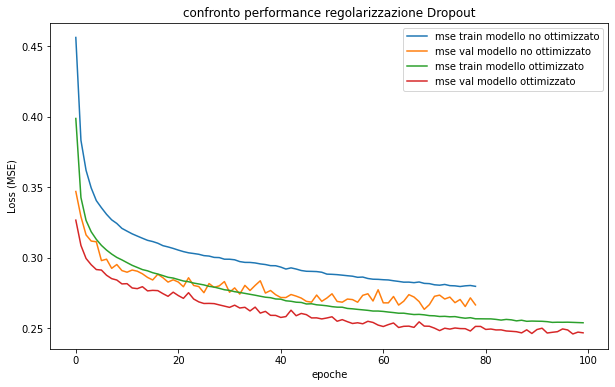

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(train_no_opt_mse, label = "mse train modello no ottimizzato")
plt.plot(val_no_opt_mse, label = "mse val modello no ottimizzato")
plt.plot(train_opt_loss, label = "mse train modello ottimizzato")
plt.plot(val_opt_loss, label = "mse val modello ottimizzato")
plt.legend()
plt.ylabel("Loss (MSE)")
plt.xlabel("epoche")
plt.title("confronto performance regolarizzazione Dropout")